# Minecraft Block Prediction

This is my first prototype of an AI which takes a photo from Minecraft and predicts where there are blocks and where there is air.

This notebook
  - Provides basic visuilization of Minecraft Block Arrays
  - Preprocesses images for training
  - Provides a naive solution to solve the problem (73% accuracy)
  - Provides a CNN solution (83% accuracy)

In [2]:
#TODO: Remove unnecessary imports 
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

from fastai.vision.all import *
from fastdownload import *
from fastbook import *
import ipyvolume as ipv
import numpy as np


/home/ben/anaconda3/envs/ml2/lib/python3.8/site-packages/fastbook/__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [3]:
train_path = Path('/home/ben/Desktop/Python/BlockDetection')
test_path = Path('/home/ben/Desktop/Python/BlockDetectionValidation')
train_files = train_path.ls()
test_files = test_path.ls()
train_files[0],  str(train_files[0].name)

(Path('/home/ben/Desktop/Python/BlockDetection/biome.minecraft.taiga_hills283.txt'),
 'biome.minecraft.taiga_hills283.txt')

In [4]:
len(train_files[train_files.map(lambda f:f.is_file())]), len(train_files)

(20180, 20181)

In [5]:
biome_types = L()
for file in train_files:
    match = re.findall('.*biome.minecraft.([a-z_]*)\d*.txt', str(file))
    if (len(match) != 0):
        biome_types.append(match[0])

biome_types = biome_types.unique()
biome_types

(#41) ['taiga_hills','desert','plains','flower_forest','giant_tree_taiga','jungle','birch_forest','taiga_mountains','mountains','taiga'...]

In [6]:
def is_air(block):
    return block == 'air' or block == "cave_air"

In [7]:
def to_tensor(data_file_path):
    df = pd.read_json(str(data_file_path))
    list_len = len(df[0][0])
    data = np.zeros((df.shape[0],df.shape[1], len(df[0][0])), dtype=np.float32)
    for x in range(0, df.shape[0]):
        for y in range(0, df.shape[1]):
            for z in range(0, list_len):
                is_block = not is_air(df[y][x][z]) 
                data[x,y,z] = 1. if is_block else 0.
    return data

In [8]:
to_tensor(train_files[0]).shape

(20, 7, 10)

In [9]:
tensor = to_tensor(Path('/home/ben/Desktop/Python/BlockDetectionValidation/biome.minecraft.birch_forest106.txt'))

#Number of air blocks
1400 - tensor.sum()

760.0

In [10]:
def to_scatter(block_tensor):
    total = 0
    a,b,c = [0],[0],[0]
    for x in range(0, block_tensor.shape[0]):
        for y in range(0, block_tensor.shape[1]):
            for z in range(0, 10):#TODO: Fix
                if (block_tensor[x][y][z] == 1):
                    a.append(x)
                    b.append(y)
                    c.append(z)
                    total = total + 1

    return np.asarray(a, dtype=np.float32), np.asarray(b, dtype=np.float32), np.asarray(c, dtype=np.float32)

tensor = to_tensor(Path('/home/ben/Desktop/Python/BlockDetectionValidation/biome.minecraft.birch_forest102.txt'))
x_out, y_out, z_out = to_scatter(tensor)

In [11]:
def show_scatter(block_tensor):
    ipv.figure()
    x_out, y_out, z_out = to_scatter(block_tensor)
    ipv.scatter(x_out, y_out, z_out)
    ipv.show()
def show_scatter_from_path(path):
    show_scatter(to_tensor(path))


In [12]:
def to_image_path(file_path):
    image_file = str(file_path).replace('BlockDetectionValidation', 'BlockDetectionValidation/screenshots')
    if "BlockDetectionValidation" not in image_file:
        image_file = image_file.replace('BlockDetection', 'BlockDetection/screenshots')
    image_file = image_file.replace('.txt', '.png')
    return image_file

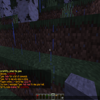

In [13]:
example_path = '/home/ben/Desktop/Python/BlockDetectionValidation/biome.minecraft.birch_forest104.txt'
show_scatter_from_path(Path(example_path))
im = to_image_path(example_path)
Image.open(im)

In [14]:
def prepare_images(path):
    data_files =path.ls()

    data_files =data_files[data_files.map(lambda f:f.is_file())]
    len(data_files)

    for data_file in data_files:
        #image_file = str(data_file).replace('BlockDetection', 'BlockDetection/screenshots')
        image_file = to_image_path(str(data_file))
        open_image = Image.open(image_file)
        if (open_image.mode != 'RGB'):
            print('Updating File to be RGB 100x100')
            Image.open(image_file).convert('RGB').save(image_file)
            Image.open(image_file).resize((100, 100)).save(image_file)

In [15]:
prepare_images(Path('/home/ben/Desktop/Python/BlockDetectionValidation'))
prepare_images(Path('/home/ben/Desktop/Python/BlockDetection'))

In [16]:
import multiprocessing

In [17]:
#def process(dataset, file):
    #dataset.


In [18]:
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
#load_size = 1000

class CustomDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.files = data_path.ls()
        self.files = self.files[self.files.map(lambda f:f.is_file())]
        #self.files = self.files[0:load_size]
        self.images = self.files.map(lambda f: self.__getimage__(f))
        self.y = self.files.map(lambda f: to_tensor(f))
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        return self.images[idx], self.y[idx]
    def __getimage__(self, path):
        #print(path)
        image_file = to_image_path(path)
        image = read_image(image_file)
        image_float = image / 255
        return image_float


In [19]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_data_folder = Path('/home/ben/Desktop/Python/BlockDetection')
test_data_folder = Path('/home/ben/Desktop/Python/BlockDetectionValidation')
train_dataloader = DataLoader(CustomDataset(train_data_folder), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(CustomDataset(test_data_folder), batch_size=64, shuffle=True)

In [20]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([64, 3, 100, 100])
torch.Size([64, 20, 7, 10])


In [21]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


Using cuda device


In [32]:
a = 0
size = len(train_dataloader.dataset)
for batch, (X, y) in enumerate(train_dataloader):
    y = y.to(device)
    y = y.reshape(-1,1400)
    a = a + torch.sum(y, dim= 0)
    #print(a.shape) 

print(a.shape)
print(a)
a = a / size
a = a > 0.5
a = a.type(torch.float)


print(a.sum() / 1400)

torch.Size([1400])
tensor([14413., 15040., 15808.,  ...,  2938.,  2954.,  2941.], device='cuda:0')
tensor(0.2857, device='cuda:0')


In [36]:
size = len(train_dataloader.dataset)
total_dif = 0
for batch, (X, y) in enumerate(train_dataloader):
    y = y.to(device)
    y = y.reshape(-1,1400)
    total_dif += (y - a).abs().sum()
    #print(a.shape) 

train_accuracy = 1 - ((total_dif) / (1400 * size))


size = len(test_dataloader.dataset)
total_dif = 0
for batch, (X, y) in enumerate(test_dataloader):
    y = y.to(device)
    y = y.reshape(-1,1400)
    total_dif += (y - a).abs().sum()
    #print(a.shape) 

test_accuracy = 1 - ((total_dif) / (1400 * size))


print('Train accuracy ' + str(train_accuracy))
print('Test accuracy ' + str(test_accuracy))



Train accuracy tensor(0.7439, device='cuda:0')
Test accuracy tensor(0.7316, device='cuda:0')


In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        y =y.reshape(-1,1400)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [22]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    total = 0
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).reshape(-1, 1400)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()            
            pred = pred > 0.5
            #print(pred.shape)
            #print('Pred shape, y shape' + str(pred.shape) + str(y.shape))
            accuracy = (pred.type(torch.float) - y).abs().sum() / (1400 * y.shape[0])      
            #print('Y sum' + str(y.sum()))
            #print(pred.type(torch.float).sum())
            #print('Acc:' + str(accuracy))
            correct += accuracy.item()
            total = total + 1
    test_loss /= num_batches
    correct /= total
    correct = 1 - correct
    print("Accuracy: " + str(correct))
    print(f"Test loss: {test_loss:>8f} \n")

In [23]:

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        #https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Dropout(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            #nn.ReLU(),          
            )
        self.layer2 =nn.Sequential(
            nn.Conv2d(64,64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            
            nn.Conv2d(64,64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(64,128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(128,128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Dropout()
            #nn.MaxPool2d(kernel_size=5, stride=2),
            #nn.Conv2d(256,256, kernel_size=5, stride=1, padding=2),
            #nn.ReLU(),
            #nn.MaxPool2d(kernel_size=5, stride=2),
            )
        self.dropout = nn.Dropout()
        self.fc1 =nn.Linear(80000, 20*7*10)#80000  #36864 #7*7*64
        #self.fc2 = nn.Linear(20*7*10, 20*7*10)
        self.fc3 = nn.Sigmoid()
        
        #self.linear_relu_stack = nn.Sequential(
        #    nn.Linear(3*100*100, 512),
        #    nn.ReLU(),
        #    nn.Linear(512, 512),
        #    nn.ReLU(),
        #    nn.Linear(512, 20*7*10)
            #nn.Sigmoid
        #)

    def forward(self, x):
        #print(x.shape)
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)#
        out = self.dropout(out)
        #print('Out size' + str(out.size()))
        out = self.fc1(out)
        #out = self.fc2(out)
        out = self.fc3(out)
        #logits = self.linear_relu_stack(x)
        return out

##model = NeuralNetwork().to(device)
#print(model)

In [24]:
model = NeuralNetwork().to(device)
#loss_fn = nn.L1Loss()#nn.BCELoss() #nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)



In [25]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(train_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)    
print("Done!")

Epoch 1
-------------------------------
loss: 0.693152  [    0/20180]
loss: 0.500489  [ 6400/20180]
loss: 0.478495  [12800/20180]
loss: 0.481296  [19200/20180]
Accuracy: 0.7644092777500981
Test loss: 0.489699 

Done!


In [26]:
def compute_dif(pred, actual):
    model.eval()
    with torch.no_grad():
        pred = pred < 0.5
        accuracy = (pred.type(torch.float) - actual).abs().sum() / (1400 * pred.size(0))
        return accuracy


In [27]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(train_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)  
print("Done!")

Epoch 1
-------------------------------
loss: 0.432971  [    0/20180]
loss: 0.428522  [ 6400/20180]
loss: 0.458958  [12800/20180]
loss: 0.484970  [19200/20180]
Accuracy: 0.7698473710080852
Test loss: 0.488767 

Epoch 2
-------------------------------
loss: 0.449430  [    0/20180]
loss: 0.450993  [ 6400/20180]
loss: 0.402605  [12800/20180]
loss: 0.374227  [19200/20180]
Accuracy: 0.7882811206838359
Test loss: 0.469235 

Epoch 3
-------------------------------
loss: 0.424212  [    0/20180]
loss: 0.406855  [ 6400/20180]
loss: 0.373642  [12800/20180]
loss: 0.390643  [19200/20180]
Accuracy: 0.7916484786116559
Test loss: 0.449420 

Epoch 4
-------------------------------
loss: 0.409904  [    0/20180]
loss: 0.357252  [ 6400/20180]
loss: 0.346799  [12800/20180]
loss: 0.366510  [19200/20180]
Accuracy: 0.7942759673232618
Test loss: 0.439383 

Epoch 5
-------------------------------
loss: 0.376451  [    0/20180]
loss: 0.386219  [ 6400/20180]
loss: 0.359027  [12800/20180]
loss: 0.329389  [19200/201

In [28]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(train_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)    
print("Done!")

Epoch 1
-------------------------------
loss: 0.307439  [    0/20180]
loss: 0.317669  [ 6400/20180]
loss: 0.351856  [12800/20180]
loss: 0.295455  [19200/20180]
Accuracy: 0.8291703598654788
Test loss: 0.378889 

Epoch 2
-------------------------------
loss: 0.276453  [    0/20180]
loss: 0.350203  [ 6400/20180]
loss: 0.283634  [12800/20180]
loss: 0.272893  [19200/20180]
Accuracy: 0.8269932257092517
Test loss: 0.382221 

Epoch 3
-------------------------------
loss: 0.272122  [    0/20180]
loss: 0.258076  [ 6400/20180]
loss: 0.304869  [12800/20180]
loss: 0.304071  [19200/20180]
Accuracy: 0.8258428366287895
Test loss: 0.386450 

Epoch 4
-------------------------------
loss: 0.290387  [    0/20180]
loss: 0.311041  [ 6400/20180]
loss: 0.270576  [12800/20180]
loss: 0.293333  [19200/20180]
Accuracy: 0.8318854570388794
Test loss: 0.371883 

Epoch 5
-------------------------------
loss: 0.327142  [    0/20180]
loss: 0.292779  [ 6400/20180]
loss: 0.309437  [12800/20180]
loss: 0.318608  [19200/201

# I don't know if anything after this works

In [29]:
test_data_folder = Path('/home/ben/Desktop/Python/BlockDetectionValidation')
test_dataloader = DataLoader(CustomDataset(test_data_folder), batch_size=64, shuffle=True)

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    #test(train_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)    
print("Done!")

Epoch 1
-------------------------------
Accuracy: 0.7751983786406724
Test loss: 1.466246 

Done!


In [41]:
def predict_image(path):
    with torch.no_grad():

        #image_file = to_image_path(data_file)
        #image = read_image(image_file)
        #image_float = image / 255

        image = read_image(path) / 255
        image_float = image.reshape(1,3,100,100).cuda()
        pred = model(image_float)#.reshape(20, 7, 10)
        pred = pred > 0.5
        return pred.detach().cpu()

In [36]:
def predict_image2(path):
    with torch.no_grad():
        image = read_image(path) / 255
        image_float = image.reshape(1,3,100,100).cuda()
        pred = model(image_float)#.reshape(20, 7, 10)
        #pred = pred > 0.5
        #return pred.detach().cpu().numpy()
        return pred

In [57]:
validation_path = Path('/home/ben/Desktop/Python/BlockDetectionValidation')
Path('/home/ben/Desktop/Python/BlockDetectionValidation/Predictions').mkdir(parents=true, exist_ok=true)
validation_files = validation_path.ls()

for file in validation_files:
    if (file.is_file()):
        image_file = to_image_path(file)
        actual = to_tensor(file)
        prediction = predict_image(image_file)
        #print(prediction.shape)
        difference = compute_dif(prediction, actual.reshape(1, -1))
        prediction = prediction.reshape(20,7,10).numpy()

        print(prediction.shape)
        print(actual.shape)

        print('Actual')
        show_scatter(actual)
        print('Prediction')
        show_scatter(prediction)
        print('Diff')
        print(type(actual))
        dif = actual - prediction
        show_scatter(dif)
        


        print(difference)
        print(file)
        print(actual.sum())
        break


        #prediction_output_path = str(file).replace('BlockDetectionValidation', 'BlockDetectionValidation/Predictions')
        #print(prediction_output_path)
        #np.savetxt(prediction_output_path, prediction)
        

(20, 7, 10)
(20, 7, 10)
Actual


Prediction


Diff
<class 'numpy.ndarray'>


tensor(0.9143)
/home/ben/Desktop/Python/BlockDetectionValidation/biome.minecraft.mountains331.txt
599.0


In [ ]:
#with torch.no_grad():
path = '/home/ben/Desktop/Python/BlockDetection/screenshots/biome.minecraft.beach106.png'
image = read_image(path) / 255
image_float = image.reshape(1,3,100,100).cuda()

pred = model(image_float).reshape(20, 7, 10)
pred = pred > 0.5
print(pred.shape)
result = pred.detach().cpu().numpy()
np.savetxt('output.csv', result)
actual = to_tensor('/home/ben/Desktop/Python/BlockDetection/biome.minecraft.beach106.txt')
actual = torch.tensor(actual)

actual.shape, pred.shape

print(pred.type())
print(actual.type())
actual_torch = torch.tensor(actual).cuda()
pred_torch = torch.tensor(pred, dtype=torch.float)

pred_torch.is_cuda

dif_torch = actual_torch - pred_torch
dif_torch.sum(), actual_torch.sum(), pred_torch.sum()


RuntimeError: [Errno 2] No such file or directory: '/home/ben/Desktop/Python/BlockDetection/screenshots/biome.minecraft.beach106.png'

In [ ]:
    #with torch.no_grad():
    #path = '/home/ben/Desktop/Python/BlockDetection/screenshots/biome.minecraft.beach106.png'
    #image = read_image(path)
    #image.resize(100, 100)
    #image_float = image / 255
    #print(image_float.shape)
    #image_float = image_float.reshape(1,3,100,100).cuda()
    #print(image_float.is_cuda)
    #pred = model(image_float)#.reshape(20, 7, 10)
    #print(str(pred))
    #pred = pred > 0.5
    #print(pred.shape)
    #result = pred.detach().cpu().numpy()
    #np.savetxt('output.csv', result)

torch.Size([3, 100, 100])
True
torch.Size([1, 1400])


In [ ]:
actual = to_tensor('/home/ben/Desktop/Python/BlockDetection/biome.minecraft.beach106.txt')

In [ ]:
type(result), result

(numpy.ndarray,
 array([[ 0.7590272 ,  1.1494421 ,  1.1465473 , ...,  0.03555972,  0.13010326, -0.38936177]], dtype=float32))

In [ ]:
def save(obj, name):
    

In [ ]:
#with torch.no_grad():
path = '/home/ben/Desktop/Python/BlockDetection/screenshots/biome.minecraft.beach106.png'
image = read_image(path) / 255
image_float = image.reshape(1,3,100,100).cuda()

pred = model(image_float).reshape(20, 7, 10)
pred = pred > 0.5
print(pred.shape)
result = pred.detach().cpu().numpy()
np.savetxt('output.csv', result)
actual = to_tensor('/home/ben/Desktop/Python/BlockDetection/biome.minecraft.beach106.txt')
actual = torch.tensor(actual)

actual.shape, pred.shape

print(pred.type())
print(actual.type())
actual_torch = torch.tensor(actual).cuda()
pred_torch = torch.tensor(pred, dtype=torch.float)

pred_torch.is_cuda

dif_torch = actual_torch - pred_torch
dif_torch.sum(), actual_torch.sum(), pred_torch.sum()


NameError: name 'read_image' is not defined